# HOW TO DETERMINE THE BEST ARIMA MODEL BASED ON TIME SERIES DATA

## BASICS

**First** some basics, let's load our libraries and check the data

**Second**  What is ARIMA?

**ARIMA**, short for **‘Auto Regressive Integrated Moving Average’** is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

- p is the order of the AR term
- q is the order of the MA term
- d is the number of differencing required to make the time series stationary

If a time series, has **seasonal patterns**, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

**We are ready, let's go!**

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#loading the CSV file
url = "Harmon_Foods.csv"
da = pd.read_csv(url, index_col = 0)

#quick glance at the data loaded in the pd
print(da.head(10),"\n")

#separating the Sales data in its own pd and exploring it
df = da['Sales'].dropna()
print(df.head(10),"\n")
da["DA"] = pd.to_numeric(da["DA"], errors='coerce')
da.dtypes


        Sales       CP         DA     SI
Month                                   
Jan-83    NaN      0.0  396776.00  113.0
Feb-83    NaN      0.0  152296.00   98.0
Mar-83    NaN      0.0  157640.00  102.0
Apr-83    NaN      0.0  246064.00  107.0
May-83    NaN  15012.0  335716.00  119.0
Jun-83    NaN  62337.0  326312.00  104.0
Jul-83    NaN   4022.0  263284.00  107.0
Aug-83    NaN   3130.0  488676.00   81.0
Sep-83    NaN    422.0   33928.00  113.0
Oct-83    NaN      0.0  224028.00   97.0 

Month
Jan-84    425075.0
Feb-84    315305.0
Mar-84    367286.0
Apr-84    429432.0
May-84    347874.0
Jun-84    435529.0
Jul-84    299403.0
Aug-84    296505.0
Sep-84    426701.0
Oct-84    329722.0
Name: Sales, dtype: float64 



Sales    float64
CP       float64
DA       float64
SI       float64
dtype: object

### STEP 1
1. Check if the series is stationary.
2. To do that you need to use the 
2.1 Augmented Dickey Fuller test <<https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/>> 
    <<https://towardsdatascience.com/7-statistical-tests-to-validate-and-help-to-fit-arima-model-33c5853e2e93>>
2.2  The test uses A/B testing with alpha = 0.5
     H0 - The series is non-stationary
     H1 - The series is stationary
2.3 Let's go one step further and decompose the data using seasonal_decompose to get
    - Trend
    - Residuals
    - Seasonality

ADF Statistic: -2.717038
p-value: 0.071136


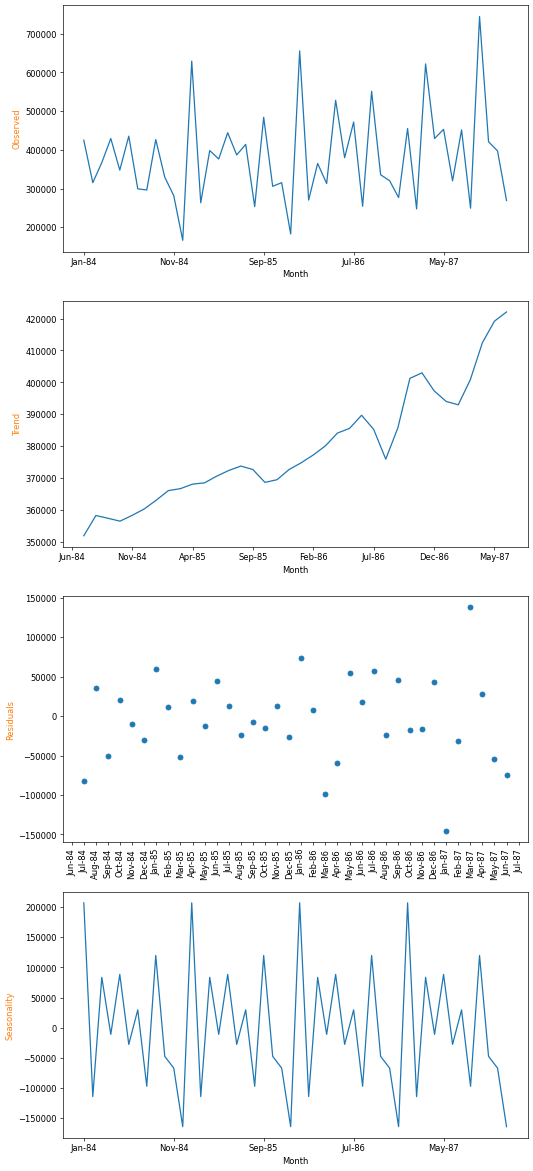

In [2]:
# Conducting ADF test:
p_value = adfuller(df)
print('ADF Statistic: %f' %p_value[0])
print('p-value: %f' %p_value[1])

# Plotting the decomposed time series:
plt.rcParams.update({'figure.dpi':60})
decomposition = seasonal_decompose(df, period=12)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,25))
decomposition.observed.plot(ax=ax1)
decomposition.trend.plot(ax=ax2)
#decomposition.resid.plot(ax=ax3)
ax3.scatter(df.index,decomposition.resid)
ax3.tick_params(axis='x', labelrotation = 90)
decomposition.seasonal.plot(ax=ax4)
ax1.set_ylabel('Observed', color="C1")       
ax1.yaxis.set_label_position('left') 
ax2.set_ylabel('Trend', color="C1")       
ax2.yaxis.set_label_position('left') 
ax3.set_ylabel('Residuals', color="C1")       
ax3.yaxis.set_label_position('left') 
ax4.set_ylabel('Seasonality', color="C1")       
ax4.yaxis.set_label_position('left') 

#fig = decomposition.plot()
plt.show()

### STEP 2
1. The p value of 0.07 indicates the series may be stationary so it may need to be differentiated to make it stationary. The p value is very close to the alpha for a 95% confidence test
2. Let's try to differentiate until the series is made stationary

An ACF function does indicate a sensible order for q or the MA order for the equation

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


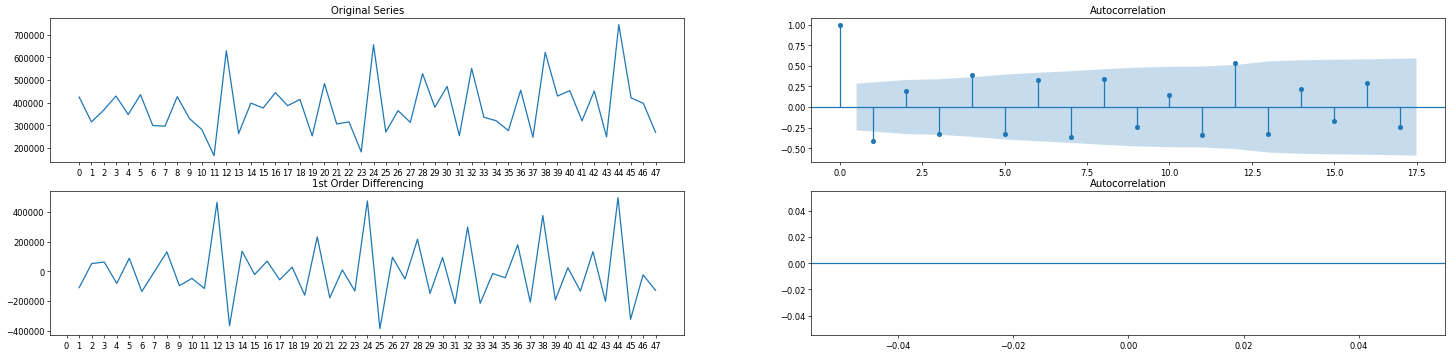

Autocorrelation for first differencing
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


In [5]:
# Original Series
fig, axes = plt.subplots(2, 2,figsize=(30,7))

#calling auto correlation function
lag_acf, confint = acf(df.diff(), nlags=len(df)-1, fft=False, alpha=0.5)

x_values = [i for i in range(len(lag_acf))]

axes[0,0].plot(df); axes[0,0].set_title('Original Series'); axes[0,0].set_xticklabels(x_values)
plot_acf(df, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing'); axes[1,0].set_xticklabels(x_values)
plot_acf(df.diff(), ax=axes[1, 1])

plt.show()
print("Autocorrelation for first differencing\n", lag_acf)



**Since the ACF function is null for the first differencing we can safely assume that the model does not require differencing.**

**Additionally q = 1 hence we have an MA model which order is 1**

### STEP 3
The final step is determining the value of the AR component of the model. This is done by inspecting the Partial Autocorrelation (PACF) plot. 
Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. 
So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

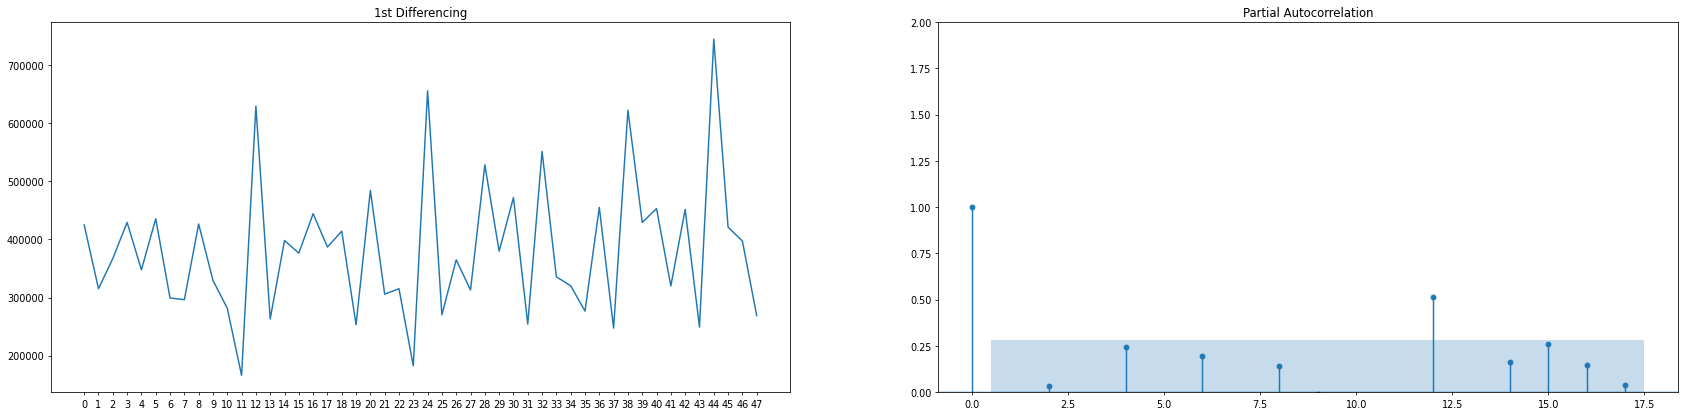

In [15]:
#Plotting the PACF
plt.rcParams.update({'figure.dpi':70})
fig, axes = plt.subplots(1, 2, figsize=(30,7))
axes[0].plot(df); axes[0].set_title('1st Differencing');axes[0].set_xticklabels(x_values)
axes[1].set(ylim=(0,2))
plot_pacf(df, ax=axes[1])

plt.show()

#calling partial correlation function
lag_pacf = pacf(df, nlags=len(df)/2 -1, method='ols')

The PACF indicates only a significant autocorrelation with the lag 12. 
**This strongly indicates seasonality!**
The model will have p = 1 as the order for AR with the lag to be used as the 12th lag. 

**BUT IS THIS TRUE?** let's evaluate a few models stationary models

In [6]:
#Finding the best model
p_values = [0, 1, 2]
d_values = range(0, 2) #this is the range for the values
q_values = range(0, 2) #this is the range for the values
warnings.filterwarnings("ignore")

def evaluate_arima_model(X, arima_order):
    # prepare training datasettrain_size = int(len(X) * 0.66)
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                #try:
                mse = evaluate_arima_model(dataset, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.3f' % (order,mse))
                #except:
                 #   continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
evaluate_models(df, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=19607445122.717
ARIMA(0, 0, 1) MSE=18633428912.306
ARIMA(0, 1, 0) MSE=51746293580.118
ARIMA(0, 1, 1) MSE=20267612672.104
ARIMA(1, 0, 0) MSE=18221174931.682
ARIMA(1, 0, 1) MSE=16919346742.246
ARIMA(1, 1, 0) MSE=24958966894.609
ARIMA(1, 1, 1) MSE=18157771386.681
ARIMA(2, 0, 0) MSE=18634886092.564
ARIMA(2, 0, 1) MSE=20095245345.693
ARIMA(2, 1, 0) MSE=26114703864.157
ARIMA(2, 1, 1) MSE=18739219194.569
Best ARIMA(1, 0, 1) MSE=16919346742.246


The best model is the one with the lowest mean square values between actual and fitted values.

***Now let's try the model!!!*** with seasonality and covariants
We assume seasonality is 12 (12 months)
Covariants:
- x1 = Consumer Packs
- x2 = Dealer Allowances
- x3 = Seasonality Index
- p = 1, d = 0, q = 1

In [7]:
exogenous = np.asarray(da[12:len(da)][['CP','DA','SI']].fillna(value=0))
exogenous.shape
df.shape
model = ARIMA(df, seasonal_order=(1,0,1,12), exog = exogenous )
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:                    Sales   No. Observations:                   48
Model:             ARIMA(1, 0, [1], 12)   Log Likelihood                -578.895
Date:                  Thu, 18 Mar 2021   AIC                           1171.790
Time:                          16:03:45   BIC                           1184.888
Sample:                      01-01-1984   HQIC                          1176.740
                           - 12-01-1987                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.683e+04   6.73e+04     -1.141      0.254   -2.09e+05    5.51e+04
x1             0.3993      0.060      6.676      0.000       0.282       0.517
x2             0.0765      0.016    

The best model is the one with the lowest mean square values between actual and fitted values.

***Now let's try the model!!!*** with seasonality and covariants but different MA value
We assume seasonality is 12 (12 months)
Covariants:
- x1 = Consumer Packs
- x2 = Dealer Allowances
- x3 = Seasonality Index
- p = 1, d = 0, q = 0

In [9]:
exogenous = np.asarray(da[12:len(da)][['CP','DA','SI']].fillna(value=0))
exogenous.shape
df.shape
model = ARIMA(df, seasonal_order=(1,0,0,12), exog = exogenous )
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:             ARIMA(1, 0, 0, 12)   Log Likelihood                -581.141
Date:                Thu, 18 Mar 2021   AIC                           1174.281
Time:                        16:04:15   BIC                           1185.509
Sample:                    01-01-1984   HQIC                          1178.524
                         - 12-01-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.683e+04   6.66e+04     -1.154      0.248   -2.07e+05    5.36e+04
x1             0.4095      0.060      6.790      0.000       0.291       0.528
x2             0.0779      0.013      6.183      0.0

**HOW accurate is this model??** SARMA (1,0,1,12)

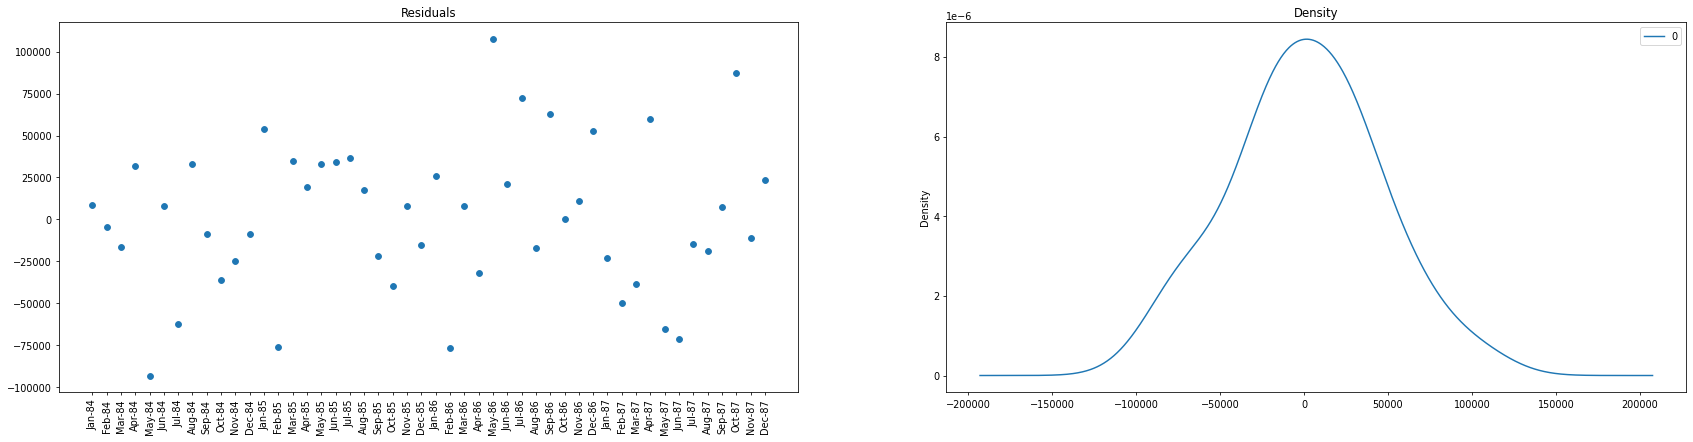

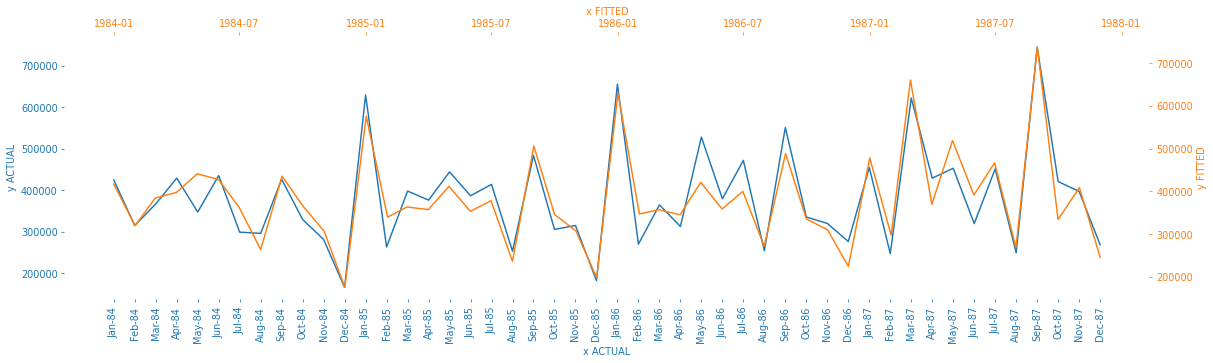

Mean Square Error (Actual vs Fitted):1914353081.104


In [11]:
# Plot residual errors
plt.rcParams.update({'figure.dpi':70})

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2,figsize=(30,7))
#residuals.plot(title="Residuals", ax=ax[0])
ax[0].set_title('Residuals');
ax[0].scatter(df.index,residuals)
ax[0].tick_params(axis='x', labelrotation = 90)
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Actual vs Fitted

fig=plt.figure(figsize=(20,5))

ax=fig.add_subplot(111, label="1",frame_on=False)
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax.plot(df, color="C0")
ax.set_xlabel("x ACTUAL", color="C0")
ax.set_ylabel("y ACTUAL", color="C0")
ax.tick_params(axis='x', colors="C0", labelrotation = 90)
ax.tick_params(axis='y', colors="C0")


ax2.plot(model_fit.predict(dynamic=False), color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('x FITTED', color="C1") 
ax2.set_ylabel('y FITTED', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

plt.show()

predictions = model_fit.predict(dynamic=False)
print ("Mean Square Error (Actual vs Fitted):%.3f" %(mean_squared_error(df, predictions)))
